# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


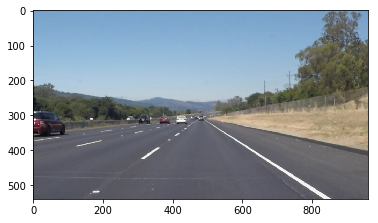

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file   
`cv2.bitwise_and()` to apply a mask to an image  

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices, debug=False):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    if debug:
        plt.figure()
        plt.suptitle('CV2 fill poly mask')
        plt.imshow(mask, cmap='Greys_r', interpolation='none')
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=1):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            # Eliminate erroneously detected lines
            angle = np.arctan2(y2 - y1, x2 - x1) * 180. / np.pi
            if ( (abs(angle) > 20.) and (abs(angle) < 90.)):
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)   
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def draw_lines_mod(line_image_gray, img_input, imshape, vertices_lr, debug = False):

    # Define x coordinate of the extreme point of the right line
    topmost_x = 3.5/8*imshape[1]
    line_image_n = np.copy(img_input)*0 #creating a blank to draw lines on
    
    for vertices_ in vertices_lr: 
        img_masked = region_of_interest(line_image_gray, vertices_)
        
        if debug:
            plt.figure()
            plt.suptitle('MAsked Image with region of interest')
            plt.imshow(img_masked, cmap='Greys_r', interpolation='none')
                
        # Compute points
        pixelpoints = cv2.findNonZero(img_masked)
        
        # Find lines and compute equation to fit lines between points
        [vx,vy,x,y] = cv2.fitLine(pixelpoints, 4,0 ,0.01 ,0.01)
        m = vy/vx
#         print("slope is", m)
        b = y - m*x  
#         print("y intercept for above slope is", b)
        
        # Compute line vertices
        topmost_y_line = m * topmost_x + b
        bottom_x_line = 1/m * ( (imshape[1]-1) - b)
        
        #Draw line
        line_image_n = cv2.line(line_image_n,( int(topmost_x),topmost_y_line),(bottom_x_line,imshape[1]-1),(255,0,0),9)
        
        # Define x coordinate of the extreme point of the right line
        topmost_x = 4.5/8*imshape[1]
    
    return line_image_n

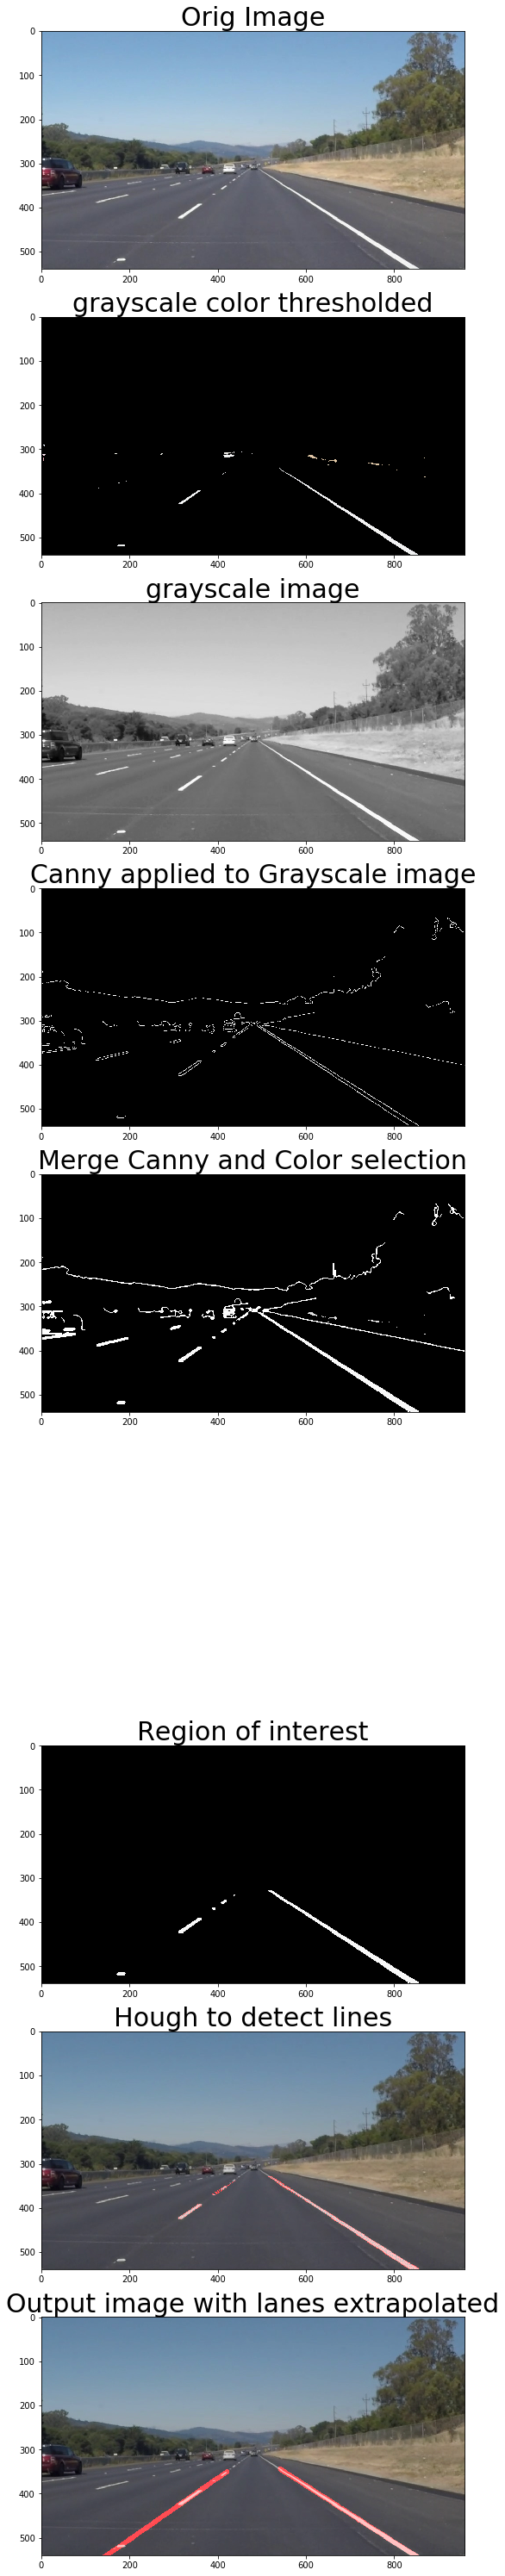

In [4]:
img_input = mpimg.imread("test_images/solidWhiteRight.jpg")
fig = plt.figure(figsize=(60,60))
a = fig.add_subplot(10,1,1)
a.set_title("Orig Image", fontsize=30)
plt.imshow(img_input)

# RGB threshold
thresholds = (img_input[:,:,0] < 220) \
            | (img_input[:,:,1] < 120) \
            | (img_input[:,:,2] < 50)

img_mask = np.copy(img_input)
img_mask[thresholds] = [0,0,0]
img_mask_gray = grayscale(img_mask)

a = fig.add_subplot(10,1,2)
a.set_title("grayscale color thresholded", fontsize=30)
plt.imshow(img_mask)

# Convert in grayscale
img_gray = grayscale(img_input)
a = fig.add_subplot(10,1,3)
a.set_title("grayscale image", fontsize=30)
plt.imshow(img_gray, cmap='Greys_r', interpolation='none')

# Define a kernel size and apply Gaussian smoothing
img_blur = gaussian_blur(img_gray, 7)

# Define our parameters for Canny and apply
img_edges = canny(img_blur, 50, 150)
a = fig.add_subplot(10,1,4)
a.set_title("Canny applied to Grayscale image", fontsize=30)
plt.imshow(img_edges, cmap='Greys_r', interpolation='none')

img_edges_dil = cv2.dilate(img_edges, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))
img_edges_dil = cv2.erode(img_edges_dil, cv2.getStructuringElement(cv2.MORPH_ERODE, (3, 3)))

# Merge Canny and Color Selection
img_merge = img_mask_gray + img_edges_dil
a = fig.add_subplot(10,1,5)
a.set_title("Merge Canny and Color selection", fontsize=30)
plt.imshow(img_merge, cmap='Greys_r', interpolation='none') 

# Create a masked edges image
imshape = img_edges.shape

# Two quadrilateral shaped RoI's one for left lane and one for right lane

pl1 = (0.0,imshape[0]) 
pl2 = (0.48*imshape[1], 0.61*imshape[0])
pl3 = (0.5*imshape[1],pl2[1])
pl4 = (pl3[0]-1.3*pl1[0],pl1[1])
pr3 = (0.55*imshape[1], pl2[1]) #57
pr4 = (imshape[1],imshape[0])
vertices_roi = np.array([[pl1,pl2,pr3,pr4]], dtype=np.int32) # Road ROI
vertices_l_roi = np.array([[pl1,pl2,pl3,pl4]], dtype=np.int32) # Left Road ROI
vertices_r_roi = np.array([[pl4,pl3,pr3,pr4]], dtype=np.int32) # Right Road ROI
vertices_lr_roi = [vertices_l_roi,vertices_r_roi]

# Region Of Interest Mask
img_masked = region_of_interest(img_merge, vertices_roi)

a = fig.add_subplot(10,1,7)
a.set_title("Region of interest", fontsize=30)
plt.imshow(img_masked, cmap='Greys_r', interpolation='none')

# Run Hough on edge detected image
line_image = np.copy(img_input)*0 #creating a blank to draw lines on
line_image = hough_lines(img_masked, 2, np.pi/180, 12, 10, 20)
img_weighted = weighted_img(line_image, img_input)
a = fig.add_subplot(10,1,8)
a.set_title("Hough to detect lines", fontsize=30)
plt.imshow(img_weighted)

# Convert in grayscale
line_image_gray = grayscale(line_image)

# Find the lines and draw them
line_image_n = draw_lines_mod(line_image_gray, img_input, imshape, vertices_lr_roi, debug=False)

#Merge original photo with lines
img_out = weighted_img(line_image_n, img_input)

a = fig.add_subplot(10,1,9)
a.set_title("Output image with lanes extrapolated", fontsize=30)
plt.imshow(img_out)
plt.show()

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
def image_with_lines(img_input, use_canny=True, debug=False, imagename=None):
    
    if imagename != None:
        print("Image is ", imagename)
    
    if debug:
        fig = plt.figure(figsize=(80,80))
        a = fig.add_subplot(6,2,1)
        a.set_title("Orig Image", fontsize=80)
        plt.imshow(img_input)
        
    # RGB threshold
    thresholds = (img_input[:,:,0] < 220) \
                | (img_input[:,:,1] < 120) \
                | (img_input[:,:,2] < 50)
            
    img_mask = np.copy(img_input)
    img_mask[thresholds] = [0,0,0]
    img_mask_gray = grayscale(img_mask)
    
    if debug:
        a = fig.add_subplot(6,2,2)
        a.set_title("grayscale image mask", fontsize=80)
        plt.imshow(img_mask)

    # Convert in grayscale
    img_gray = grayscale(img_input)
    if debug:
        a = fig.add_subplot(6,2,3)
        a.set_title("grayscale image", fontsize=80)
        plt.imshow(img_gray, cmap='Greys_r', interpolation='none')

    # Define a kernel size and apply Gaussian smoothing
    img_blur = gaussian_blur(img_gray, 7)
    
    # Define our parameters for Canny and apply
    img_edges = canny(img_blur, 50, 150)
    if debug:
        a = fig.add_subplot(6,2,4)
        a.set_title("Canny applied to Grayscale image", fontsize=80)
        plt.imshow(img_edges, cmap='Greys_r', interpolation='none')
       
    img_edges_dil = cv2.dilate(img_edges, cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 5)))
    img_edges_dil = cv2.erode(img_edges_dil, cv2.getStructuringElement(cv2.MORPH_ERODE, (3, 3)))
    
    if debug:
        a = fig.add_subplot(6,2,5)
        a.set_title("Dilate joins and erode removes noise", fontsize=80)
        plt.imshow(img_edges_dil, cmap='Greys_r', interpolation='none')

    # Merge Canny and Color Selection
    img_merge = img_mask_gray + img_edges_dil
    
    if debug:
        a = fig.add_subplot(6,2,6)
        a.set_title("Merge Canny and Color selection", fontsize=80)
        plt.imshow(img_merge, cmap='Greys_r', interpolation='none')     
    
    # Create a masked edges image
    imshape = img_edges.shape
    
    # Two quadrilateral shaped RoI's one for left lane and one for right lane
     
    pl1 = (0.0,imshape[0]) 
    pl2 = (0.48*imshape[1], 0.61*imshape[0])
    pl3 = (0.5*imshape[1],pl2[1])
    pl4 = (pl3[0]-1.3*pl1[0],pl1[1])
    pr3 = (0.55*imshape[1], pl2[1]) #57
    pr4 = (imshape[1],imshape[0])
    vertices_roi = np.array([[pl1,pl2,pr3,pr4]], dtype=np.int32) # Road ROI
    vertices_l_roi = np.array([[pl1,pl2,pl3,pl4]], dtype=np.int32) # Left Road ROI
    vertices_r_roi = np.array([[pl4,pl3,pr3,pr4]], dtype=np.int32) # Right Road ROI
    vertices_lr_roi = [vertices_l_roi,vertices_r_roi]
    
    # Region Of Interest Mask
    if (use_canny):
        img_in = img_merge
    else:
        img_in = img_mask_gray
        
    img_masked = region_of_interest(img_in, vertices_roi)
    
    if debug:
        a = fig.add_subplot(6,2,7)
        a.set_title("Region of interest", fontsize=80)
        plt.imshow(img_masked, cmap='Greys_r', interpolation='none')
        
    # Run Hough on edge detected image
    line_image = np.copy(img_input)*0 #creating a blank to draw lines on
    line_image = hough_lines(img_masked, 2, np.pi/180, 12, 10, 20)
    
    if debug:
        img_weighted = weighted_img(line_image, img_input)
        a = fig.add_subplot(6,2,8)
        a.set_title("Hough on Masked image", fontsize=80)
        plt.imshow(img_weighted)

    # Convert in grayscale
    line_image_gray = grayscale(line_image)
    
    if debug:
        a = fig.add_subplot(6,2,9)
        a.set_title("Line image grayscale", fontsize=80)
        plt.imshow(line_image_gray)

    # Find the lines and draw them
    line_image_n = draw_lines_mod(line_image_gray, img_input, imshape, vertices_lr_roi, debug=False)
    
    #Merge original photo with lines
    img_out = weighted_img(line_image_n, img_input)
   
    if debug:
        a = fig.add_subplot(6,2,10)
        a.set_title("Output image with lanes traced", fontsize=80)
        plt.imshow(img_out)
        plt.show()

    return img_out

# Test on Images

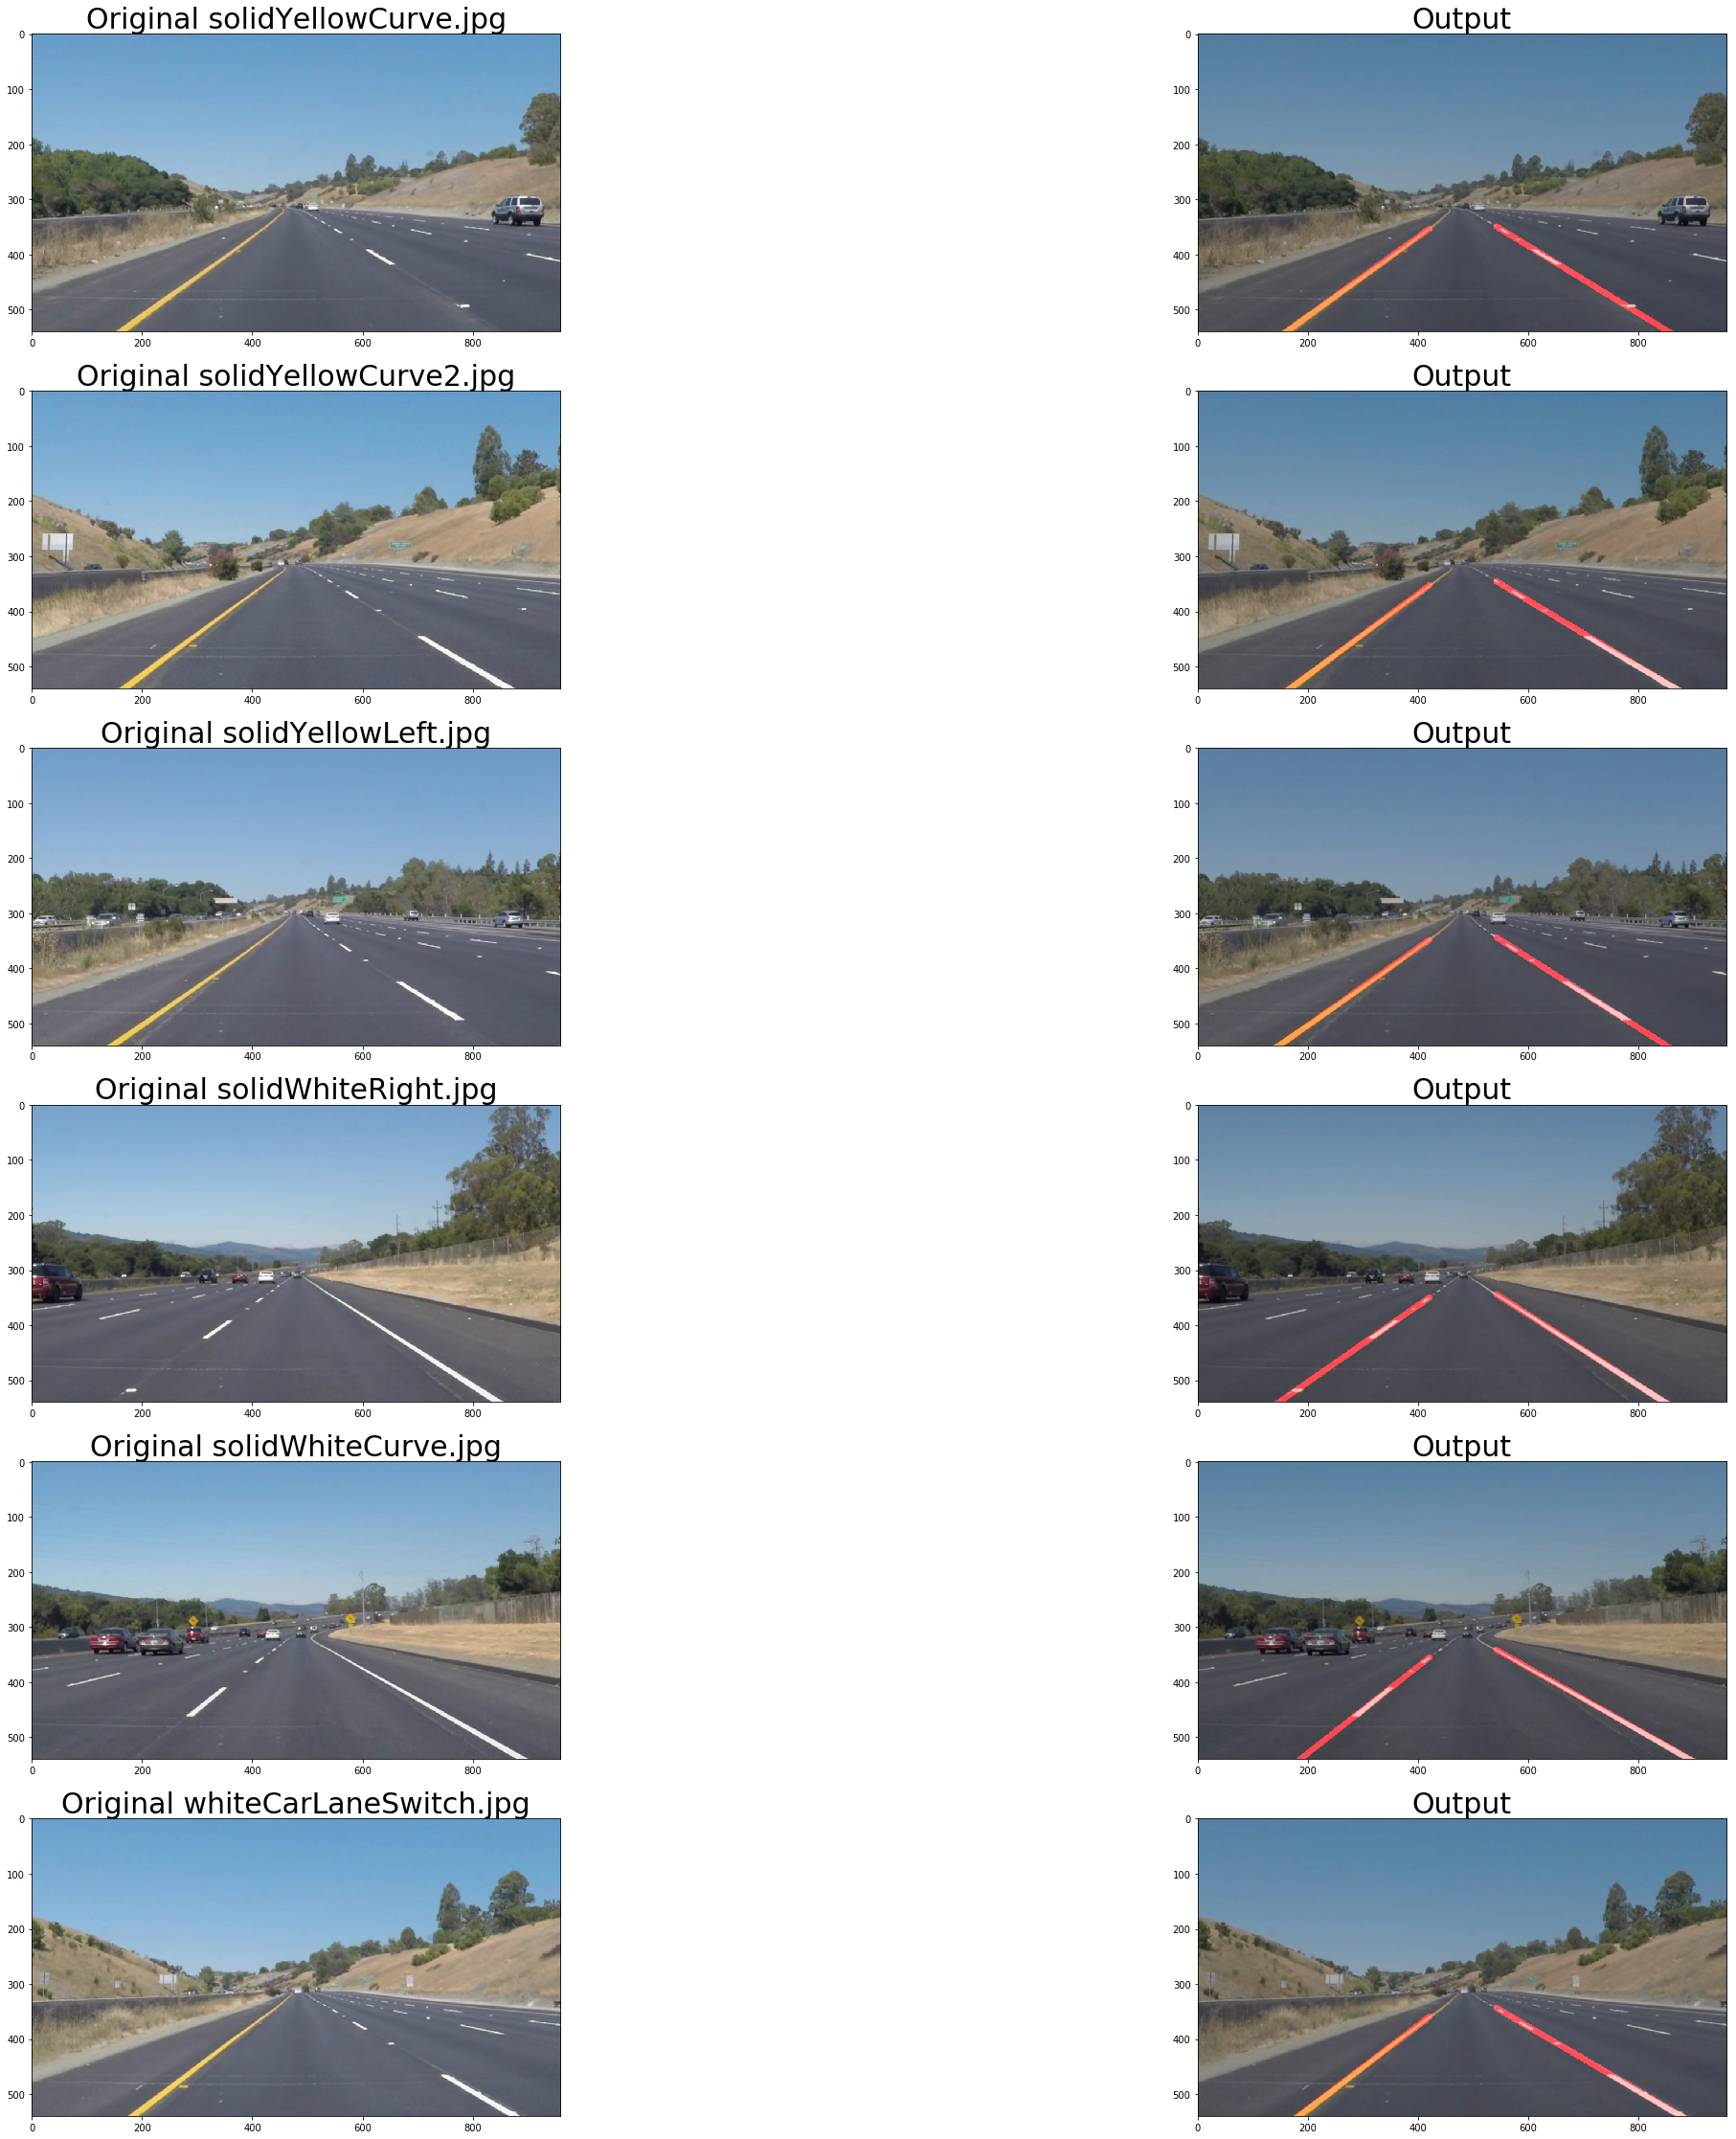

In [6]:
# Read from disk and find the lines
img_dir = "test_images/"
out_dir = "test_images_output/"

fig3 = plt.figure(figsize=(40,40))

cnt = 1
for img_name in os.listdir(img_dir):
#     print('Image is ', img_name)
    img_input = mpimg.imread(img_dir + img_name)
    a = fig3.add_subplot(6,2,(cnt*2)-1)
    a.set_title('Original %s' %img_name, fontsize=30)
    plt.imshow(img_input) 
    img_out = image_with_lines(img_input, True, False)
    a = fig3.add_subplot(6,2,cnt*2)
    a.set_title("Output", fontsize=30)
    plt.imshow(img_out)
    img_out_rgb = cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
    cv2.imwrite('test_images_output/output_' + img_name ,img_out_rgb)
    cnt = cnt + 1


Image is  challenge_debug/image.jpg


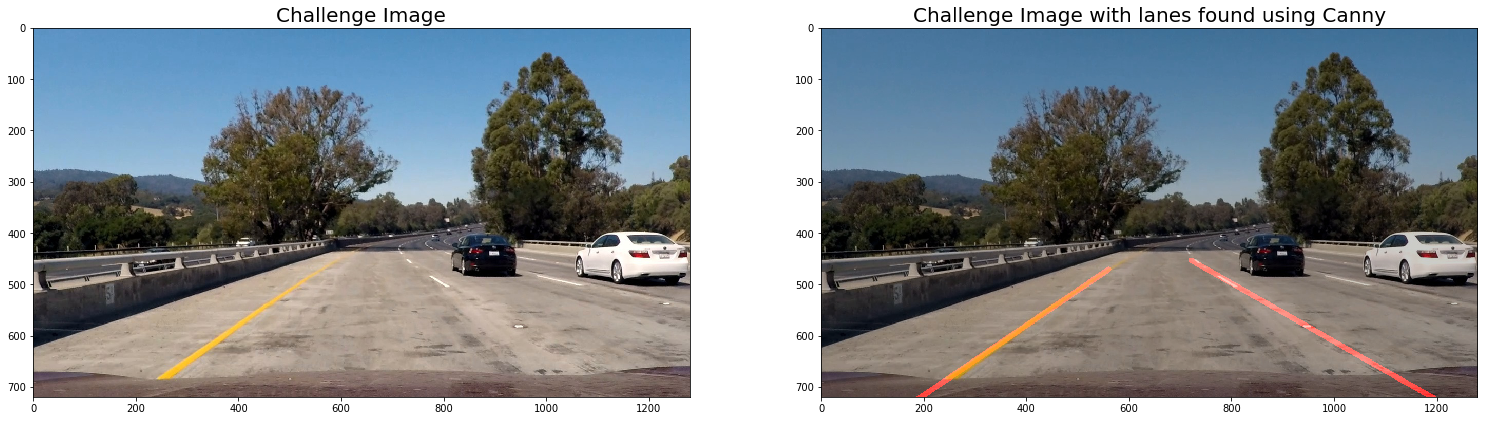

True

In [7]:
img_input = mpimg.imread('challenge_debug/image.jpg')
fig1 = plt.figure(figsize=(40,40))
a = fig1.add_subplot(1,3,1)
a.set_title("Challenge Image", fontsize=20)
plt.imshow(img_input) 
img_out_with_canny = image_with_lines(img_input, True, debug=False, imagename='challenge_debug/image.jpg')
a = fig1.add_subplot(1,3,2)
a.set_title("Challenge Image with lanes found using Canny", fontsize=20)
plt.imshow(img_out_with_canny)
plt.show()


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return image_with_lines(image, True, debug=False)

In [10]:
def process_image_no_canny(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return image_with_lines(image, False, debug=False)

In [13]:
white_output = 'test_videos_output/white_output.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/white_output.mp4
[MoviePy] Writing video test_videos_output/white_output.mp4


100%|█████████▉| 221/222 [00:11<00:00, 18.70it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/white_output.mp4 

CPU times: user 27.7 s, sys: 316 ms, total: 28.1 s
Wall time: 12.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [15]:
yellow_output = 'test_videos_output/yellow_output.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/yellow_output.mp4
[MoviePy] Writing video test_videos_output/yellow_output.mp4


100%|█████████▉| 681/682 [00:37<00:00, 18.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/yellow_output.mp4 

CPU times: user 1min 29s, sys: 724 ms, total: 1min 30s
Wall time: 37.6 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))